In [1]:
import sys
sys.path.append('..')

In [2]:
import explainer

In [3]:
import numpy as np
import torch
import networkx as nx

### Load model
Pretrained model using [`transformers`](https://github.com/huggingface/transformers), GLUE datasets and scripts can be found [**here**](https://github.com/huggingface/transformers/tree/master/examples/text-classification)

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification

MODEL_PATH = '../glue/SST-2/output/'
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = BertForSequenceClassification.from_pretrained(MODEL_PATH, output_attentions=True).eval()

### Set explainer

In [5]:
ex = explainer.BERTExplainer('seq_cls')

In [6]:
@torch.no_grad()
def test(query, start_layer_index=6, topk=32, **kwargs):
    inputs = tokenizer(query, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    logits, attns = model(**inputs)
    probs = torch.softmax(logits, -1)[0]
    label, score = torch.argmax(probs), torch.max(probs)
    print(f'=====Label: {label}, score: {score:4f}=====')
    # convert to numpy and transpose, [num_heads, seq_len, seq_len] => [seq_len, seq_len, num_heads]
    attention_weights = [_.squeeze().permute(1, 2, 0).numpy() for _ in attns]
    path_scores, lattice = ex.explain(tokens, attention_weights, start_layer_index=start_layer_index, topk=topk, **kwargs)

### Test cases

=====Label: 0, score: 0.999689=====


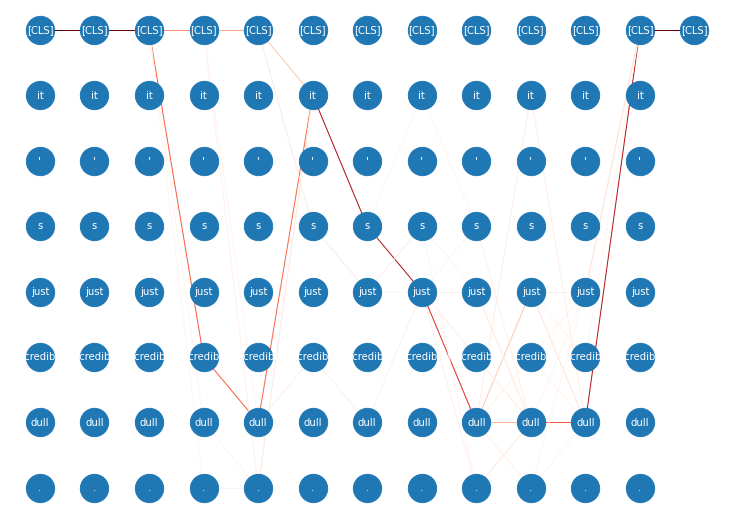

In [7]:
# Total 13 layers (including input)
# The first 3 layers seems helpless
test("it's just incredibly dull.", start_layer_index=0, figsize=(10,7))

=====Label: 1, score: 0.999929=====


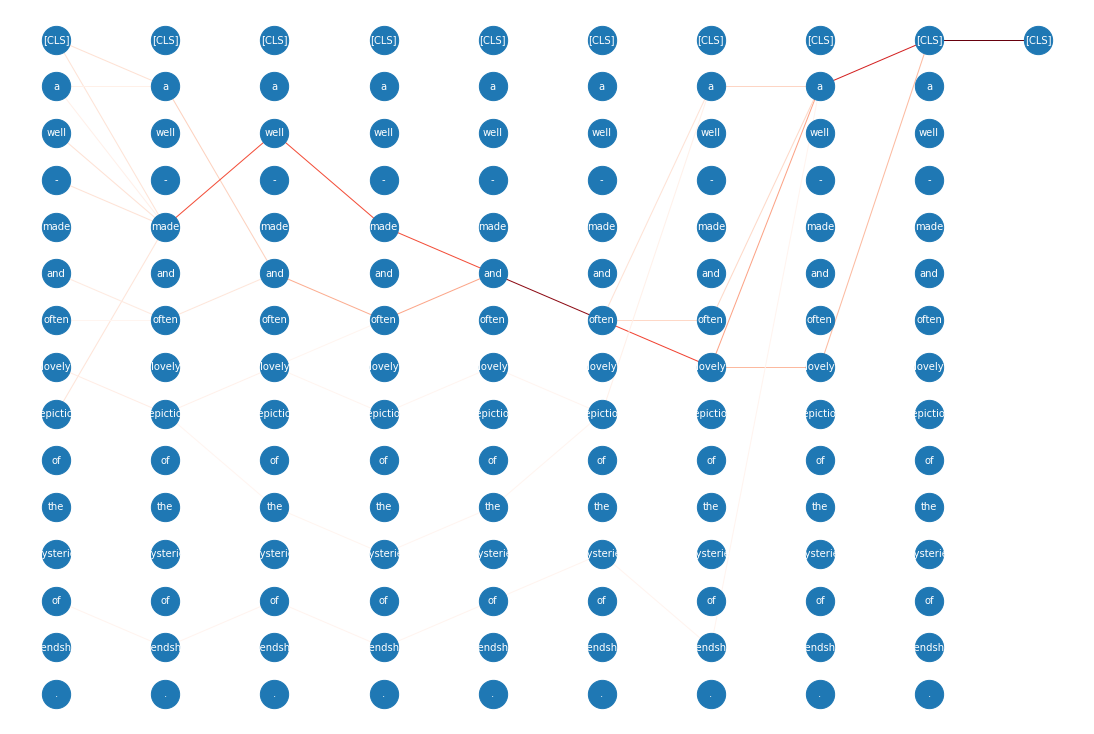

In [8]:
# a claer path
test("a well-made and often lovely depiction of the mysteries of friendship.", start_layer_index=3, figsize=(15, 10))

=====Label: 1, score: 0.999728=====


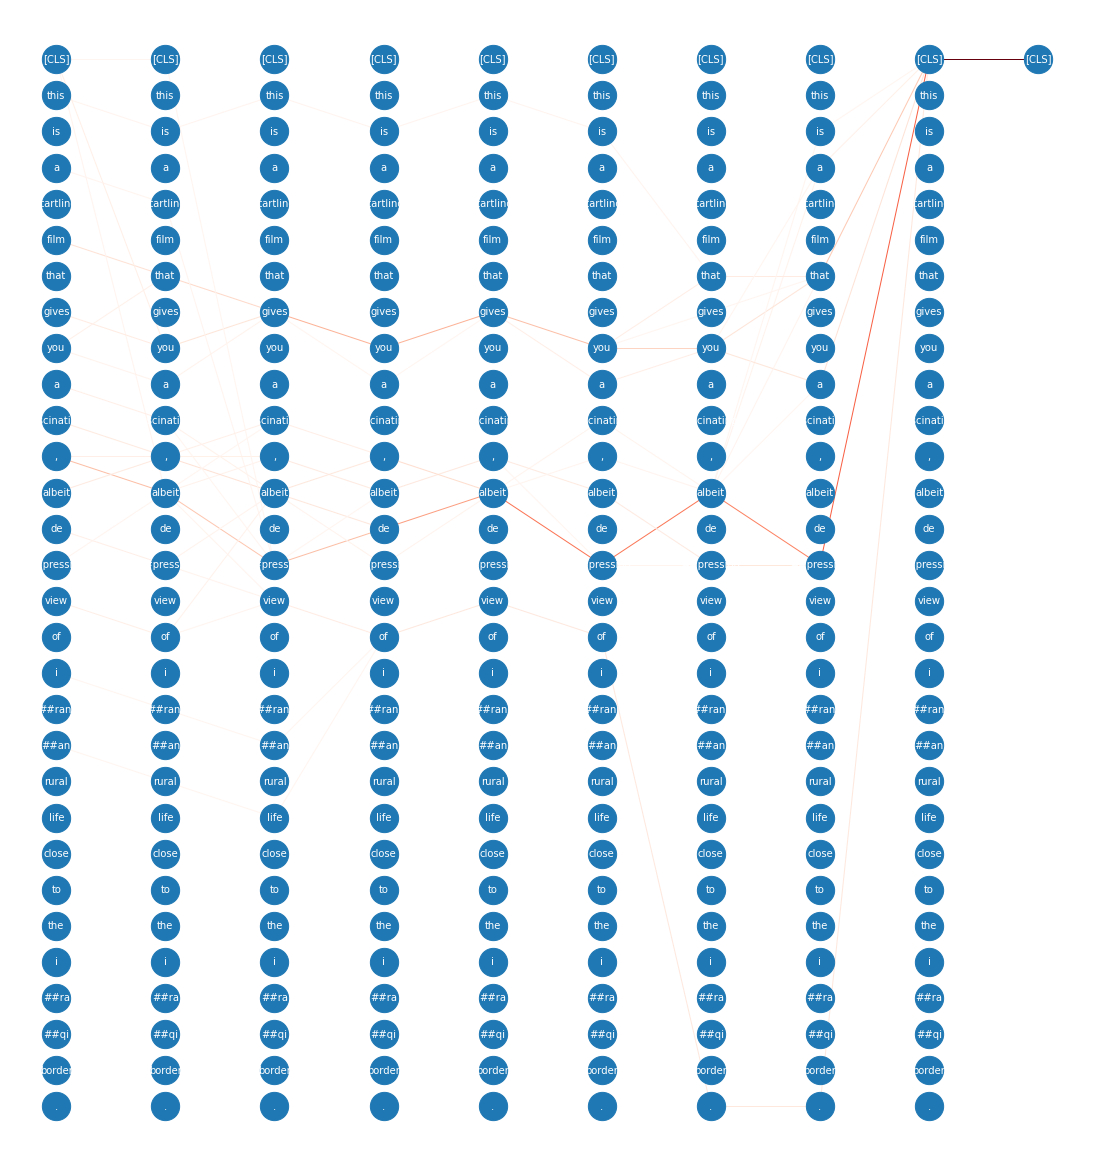

In [9]:
# albeit depressing == not depressing (??? sigh...)
test("this is a startling film that gives you a fascinating , albeit depressing view of iranian rural life close to the iraqi border .", topk=64, start_layer_index=3, figsize=(15, 16))

=====Label: 1, score: 0.999933=====


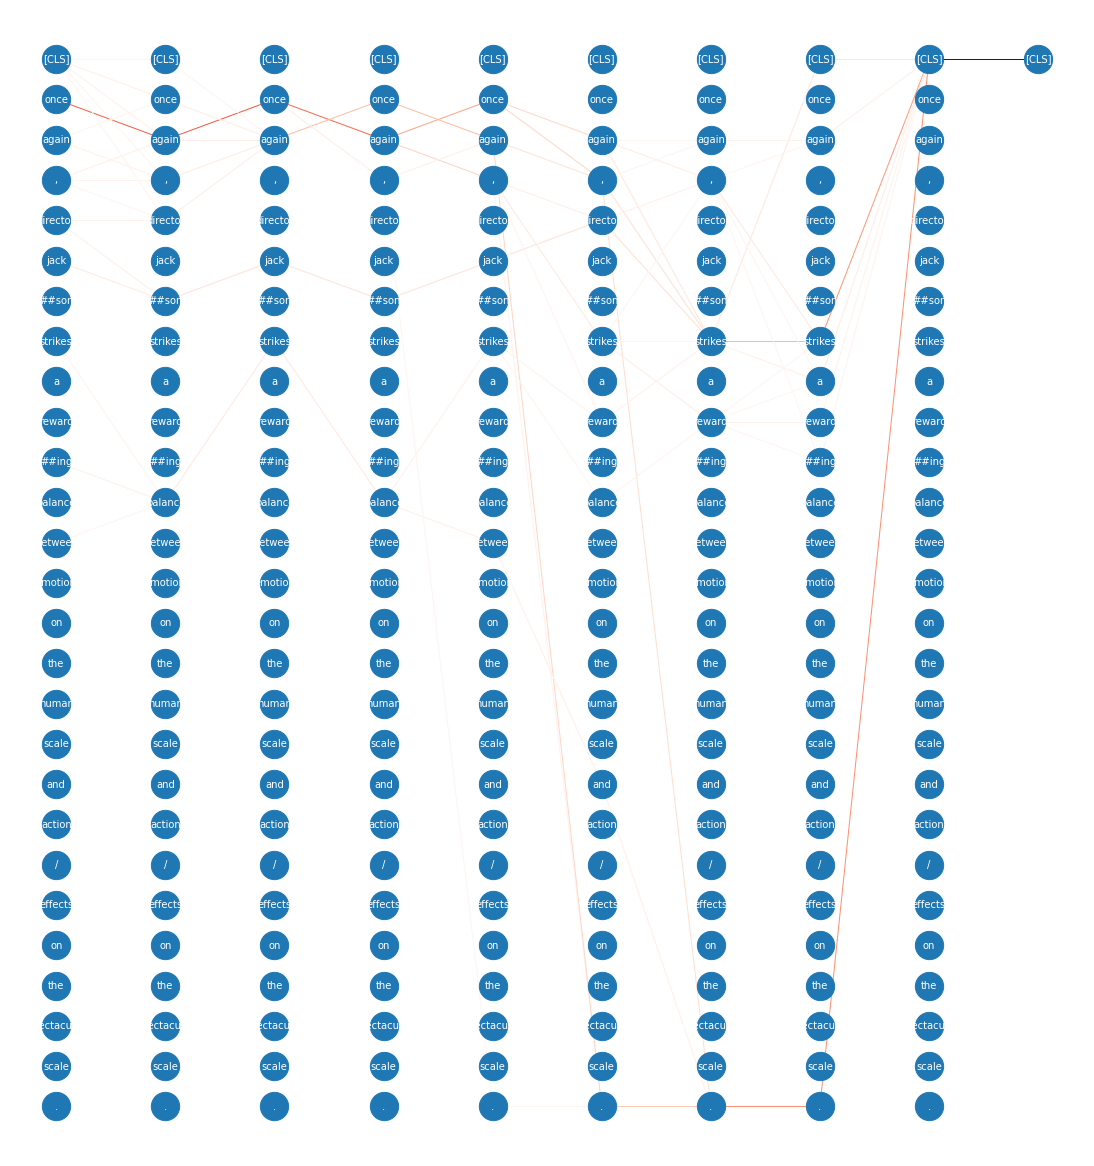

In [10]:
# once again?
test("once again , director jackson strikes a rewarding balance between emotion on the human scale and action/effects on the spectacular scale .", topk=64, start_layer_index=3, figsize=(15, 16))

=====Label: 0, score: 0.999040=====


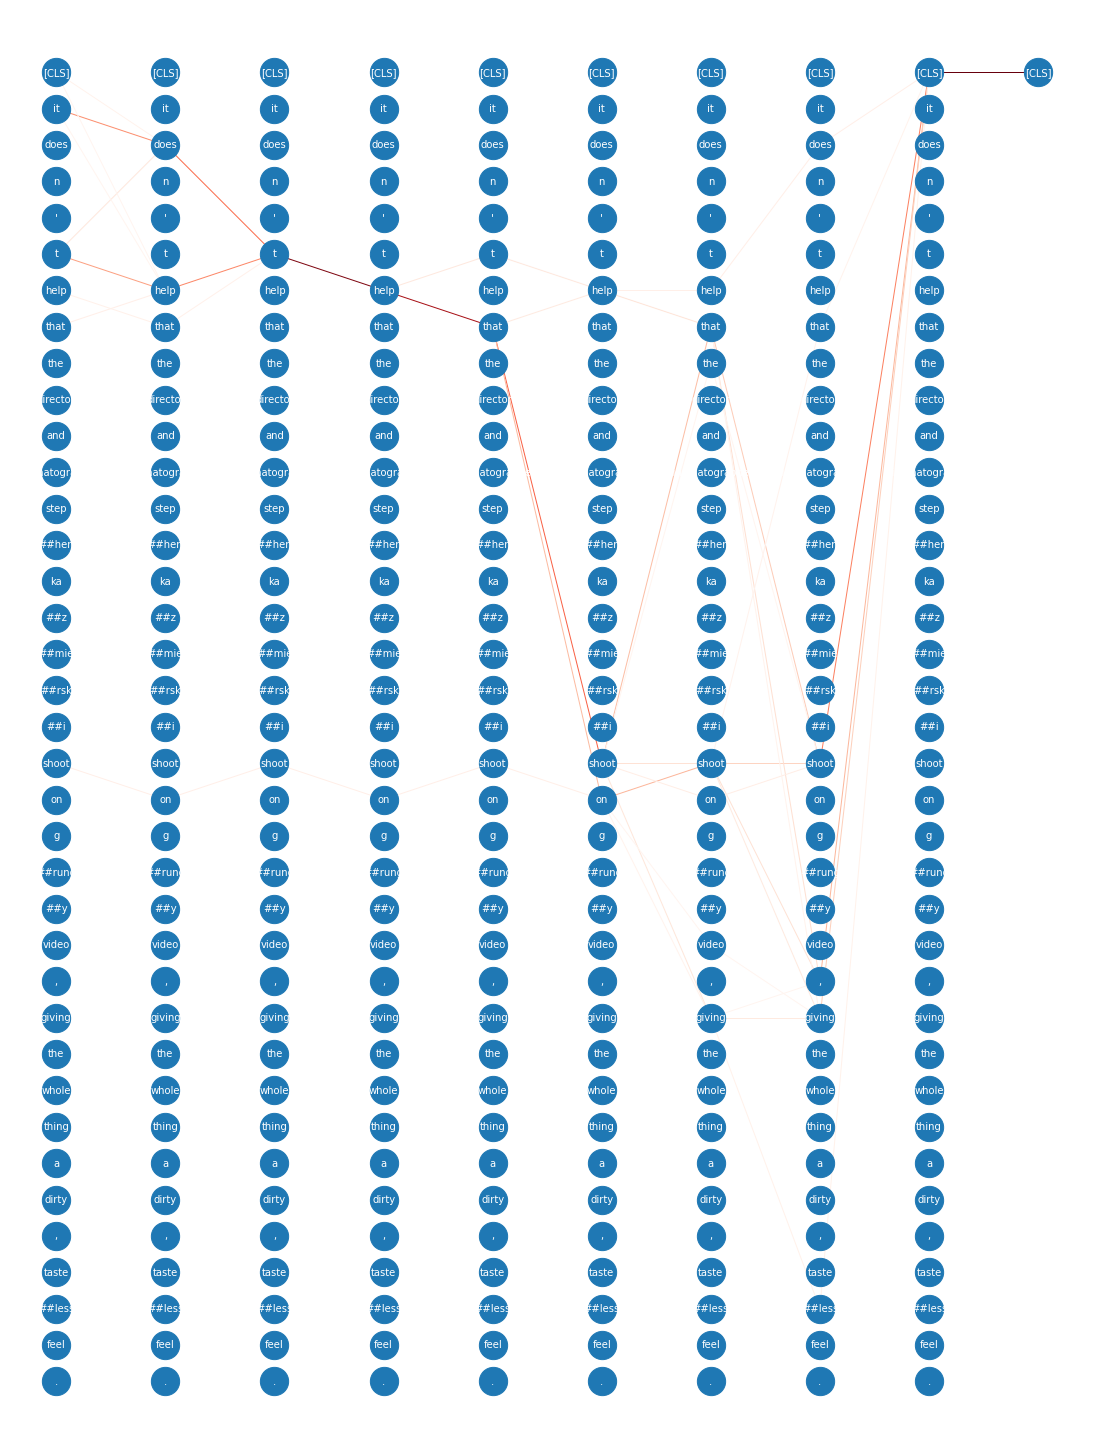

In [11]:
test("it does n't help that the director and cinematographer stephen kazmierski shoot on grungy video , giving the whole thing a dirty , tasteless feel .", topk=64, start_layer_index=3, figsize=(15, 20))